In [1]:
import os
import shutil
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.metrics import Precision, Recall, Accuracy, F1Score
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf 


In [2]:
random.seed(422)
tf.random.set_seed(422)

In [3]:
def format_filename(suffix_number, padding=5, prefix="img_", extension="jpeg"):
    formatted_number = str(suffix_number).zfill(padding)
    filename = f"{prefix}{formatted_number}.{extension}"
    return filename

def create_dir(directory_path, remove_if_exists=True):
    # Supprimer le répertoire existant s'il existe
    if os.path.exists(directory_path) and remove_if_exists:
        shutil.rmtree(directory_path)

    # Créer le nouveau répertoire
    os.makedirs(directory_path, exist_ok=(not remove_if_exists))

In [4]:
# Chemin vers le répertoire racine
root_path = "./data/"
raw_path = os.path.join(root_path, 'raw')
proc_path = os.path.join(root_path, 'proc')

# Créer les répertoires train et test
train_path = os.path.join(proc_path, "train")
val_path = os.path.join(proc_path, "val")
test_path = os.path.join(proc_path, "test")

create_dir(train_path)
create_dir(val_path)
create_dir(test_path)

# Liste des classes (yes, no)
classes = ["yes", "no"]

file_mapping = []

counter = 0

# Pour chaque classe


In [5]:
for class_name in classes:
    class_path = os.path.join(raw_path, class_name)
    images = os.listdir(class_path)
    
    # Mélanger aléatoirement les images
    random.shuffle(images)
    
    # Calculer la séparation des données (60/20/20)
    val_split_index = int(0.6 * len(images))
    test_split_index = int(0.8 * len(images))
    
    # Diviser les données en ensembles d'entraînement et de test
    train_images = images[:val_split_index]
    val_images = images[val_split_index: test_split_index]
    test_images = images[test_split_index:]
    
    # Créer les répertoires de classe dans les ensembles d'entraînement et de test
    train_class_path = os.path.join(train_path, class_name)
    val_class_path = os.path.join(val_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    
    create_dir(train_class_path)
    create_dir(val_class_path)
    create_dir(test_class_path)


    for dataset_name, dataset_images, dataset_class_path in [('train', train_images, train_class_path), 
                                                             ('val', val_images, val_class_path),
                                                             ('test', test_images, test_class_path)]:
        for image in dataset_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(dataset_class_path, format_filename(counter))
            shutil.copy(src, dst)
            file_mapping += [{'raw_img_path': src, 'proc_img_path': dst, 'class_name': class_name, 'dataset_name': dataset_name}]
            counter += 1

df = pd.DataFrame.from_records(file_mapping)
print(df.head())
images = os.listdir(class_path)
print(f"Found {len(images)} images in {class_path}")

df.to_csv(os.path.join(root_path, 'file_mapping.csv'), index=False, header=True)
print(df.columns.tolist())
df.groupby(['dataset_name', 'class_name']).count()


              raw_img_path                         proc_img_path class_name  \
0   ./data/raw\yes\Y17.jpg  ./data/proc\train\yes\img_00000.jpeg        yes   
1   ./data/raw\yes\Y90.jpg  ./data/proc\train\yes\img_00001.jpeg        yes   
2  ./data/raw\yes\Y158.JPG  ./data/proc\train\yes\img_00002.jpeg        yes   
3  ./data/raw\yes\Y146.JPG  ./data/proc\train\yes\img_00003.jpeg        yes   
4  ./data/raw\yes\Y161.JPG  ./data/proc\train\yes\img_00004.jpeg        yes   

  dataset_name  
0        train  
1        train  
2        train  
3        train  
4        train  
Found 98 images in ./data/raw\no
['raw_img_path', 'proc_img_path', 'class_name', 'dataset_name']


raw_img_path  proc_img_path
dataset_name class_name                             
test         no                    20             20
             yes                   31             31
train        no                    58             58
             yes                   93             93
val          no                    20             20
             yes                   31             31

In [6]:
def load_images(path_to_folder):
    # Liste des classes (dossiers "yes" et "no")
    classes = ["yes", "no"]
    classes_enc = {'yes': 1, 'no': 0}

    # Compter le nombre total d'images pour allouer les tableaux numpy
    total_images = sum(len(os.listdir(os.path.join(path_to_folder, class_name))) for class_name in classes)

    X = [None] * total_images  # Préallouer pour les images
    y = [None] * total_images  # Préallouer pour les labels


    last_index = 0
    
    # Parcourir chaque classe
    for class_name in classes:
        class_path = os.path.join(path_to_folder, class_name)

        # Parcourir chaque image dans la classe
        for idx, image_name in enumerate(os.listdir(class_path)):
            image_path = os.path.join(class_path, image_name)

            # Lire l'image avec OpenCV
            image = cv2.imread(image_path)

            # Ajouter l'image et le label aux tableaux X et y
            X[last_index + idx] = image
            y[last_index + idx] = classes_enc[class_name]

        last_index = last_index + idx + 1

    return np.array(X, dtype='object'), np.array(y)

In [7]:
X_train, y_train = load_images(train_path)
X_val, y_val = load_images(val_path)
X_test, y_test = load_images(test_path)

In [8]:
def display_images(X, y, n):
    # Filtrer les images par classe
    yes_images =  X[y == 1][:n]
    no_images = X[y == 0][:n]

    # Calculer le nombre de lignes et colonnes pour chaque classe
    n_rows = int(math.sqrt(n))
    n_cols = math.ceil(n / n_rows)

    # Créer la figure pour la classe "yes"
    fig_yes, axs_yes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    fig_yes.suptitle('Class: Yes')

    # Afficher des images de la classe "yes"
    for i in range(min(n, len(yes_images))):
        axs_yes[i // n_cols, i % n_cols].imshow(yes_images[i])

    # Créer la figure pour la classe "no"
    fig_no, axs_no = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    fig_no.suptitle('Class: No')

    # Afficher des images de la classe "no"
    for i in range(min(n, len(no_images))):
        axs_no[i // n_cols, i % n_cols].imshow(no_images[i])

    plt.show()

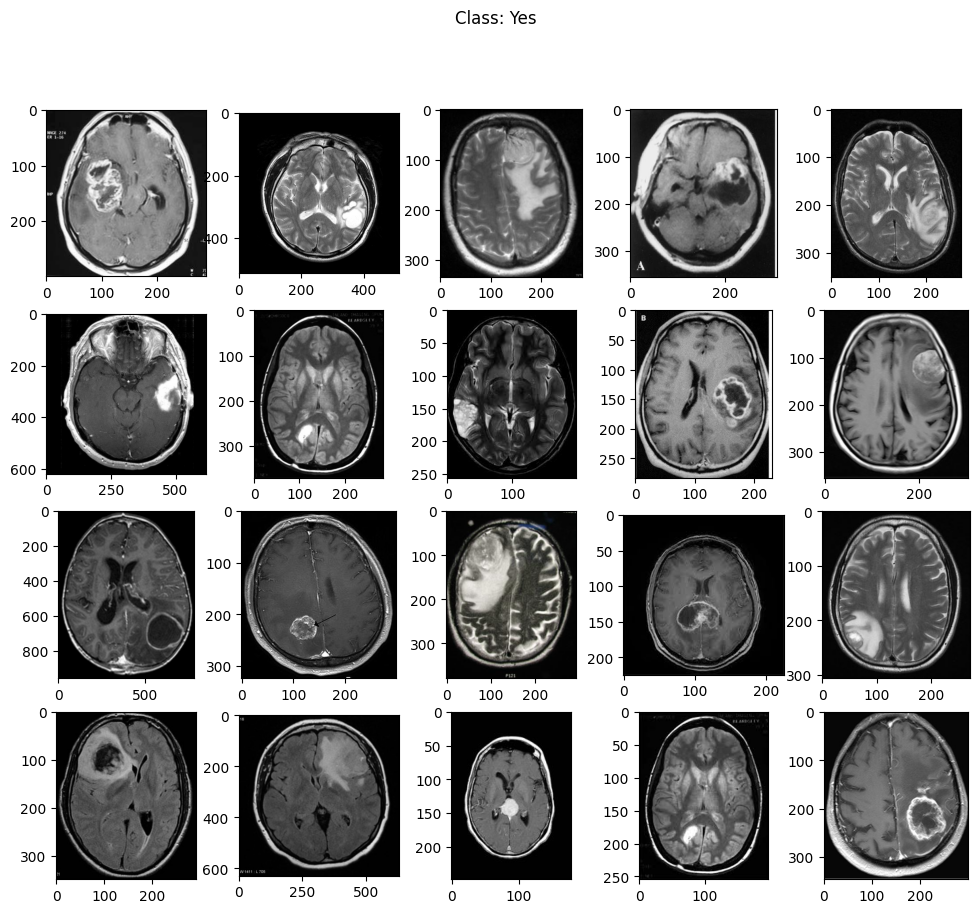

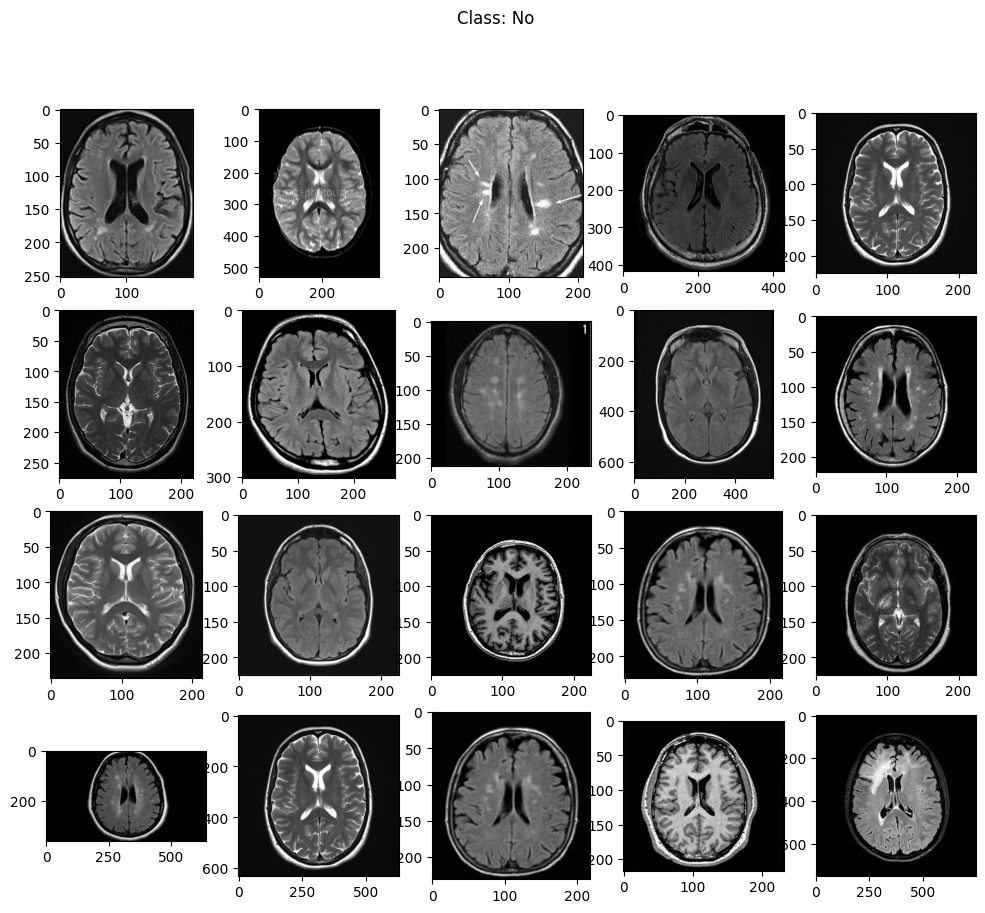

In [9]:
# Utilisation de la fonction avec X et y provenant du train
display_images(X_train, y_train, n=20)

In [10]:
def normalize_images(X, target_size):
    normalized_images = [None] * len(X)

    for i, img in enumerate(X):
        if len(img.shape) == 3:
            # Convertir en niveaux de gris si c'est pas déjà le cas
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Appliquer un filtre pour supprimer le bruit (par exemple, un filtre gaussien)
        denoised_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

        # Détecter les contours pour trouver le crop optimal
        _, thresh = cv2.threshold(denoised_img, 30, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Trouver le contour avec la plus grande aire
            max_contour = max(contours, key=cv2.contourArea)

            # Obtenir les coordonnées du rectangle englobant
            x, y, w, h = cv2.boundingRect(max_contour)

            # Cropper l'image pour obtenir la région d'intérêt
            cropped_img = img[y:y+h, x:x+w]

            # Redimensionner à target_size (pour s'assurer que toutes les images ont la même taille)
            normalized_images[i] = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_AREA)
        else:
            # Redimensionner à target_size si aucun contour n'est détecté
            normalized_images[i] = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    return np.array(normalized_images)

In [11]:
# Utilisation de la fonction avec X (images non normalisées) et la taille cible
target_size = (224, 224)
X_train_norm = normalize_images(X_train, target_size)
X_val_norm = normalize_images(X_val, target_size)
X_test_norm = normalize_images(X_test, target_size)

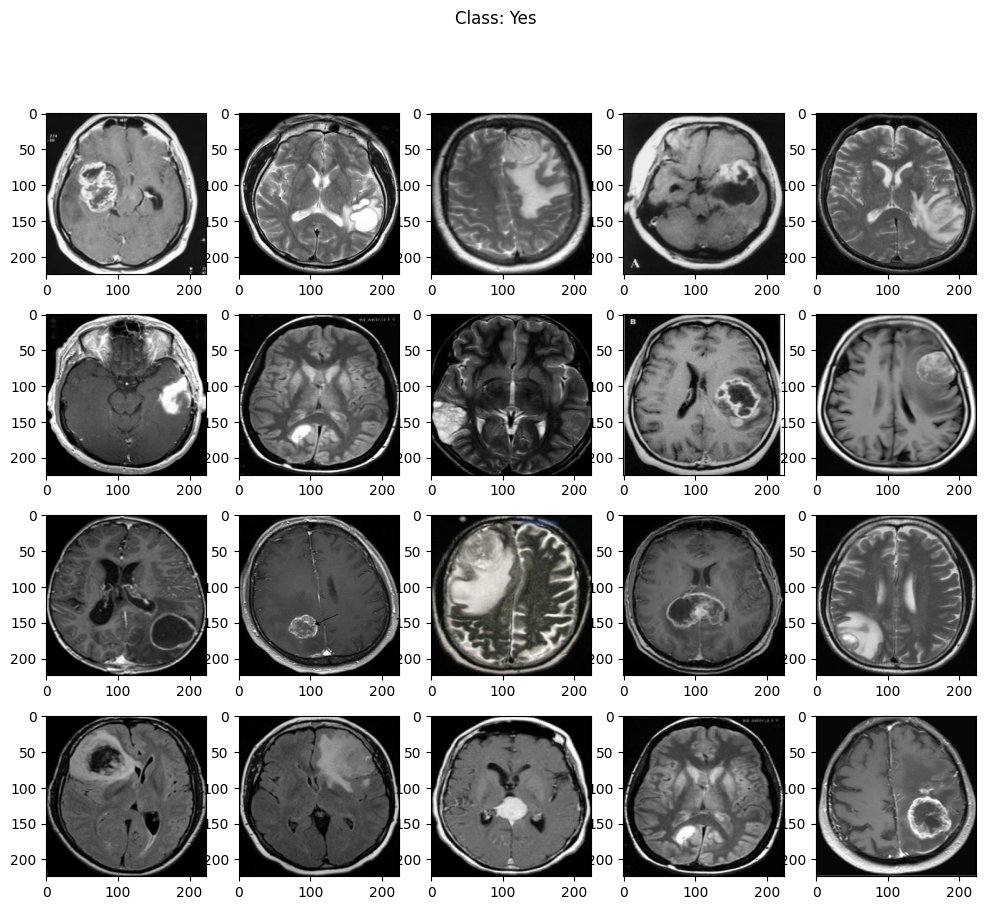

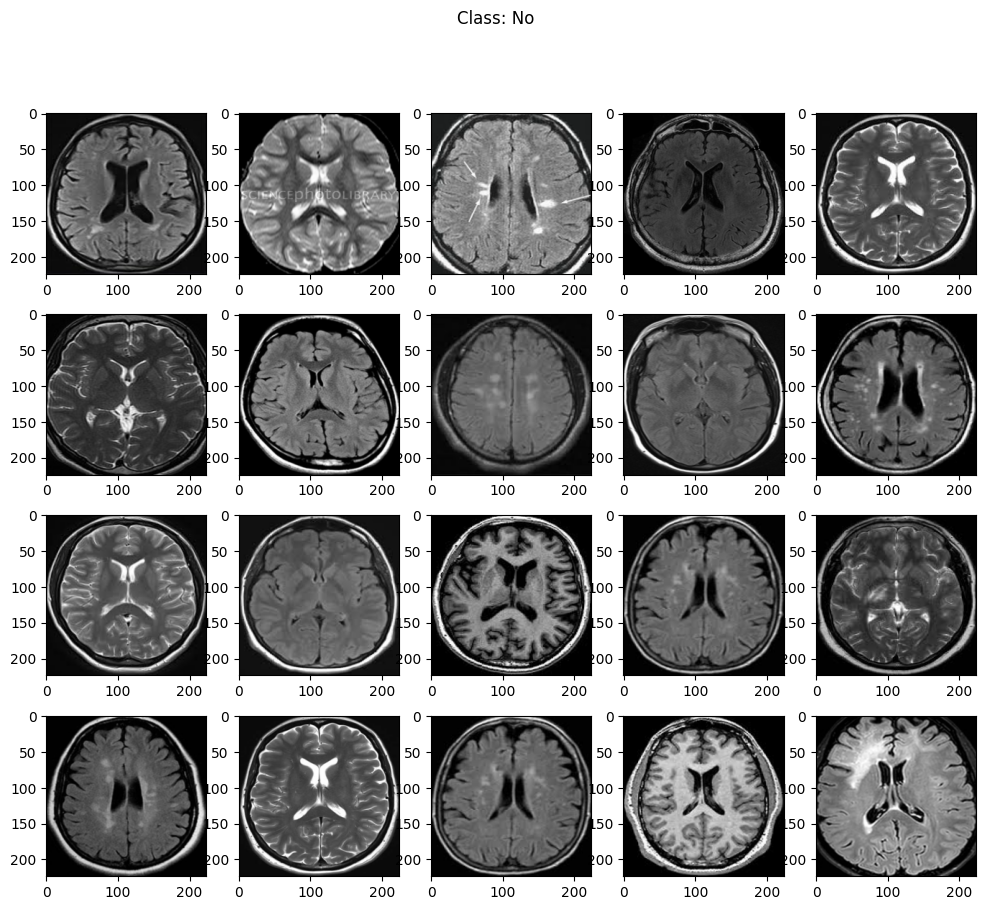

In [12]:
display_images(X_train_norm, y_train, 20)

In [13]:
# Créer un modèle VGG-16 pré-entraîné (ne pas inclure la couche dense finale)
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

# figer les poids du VGG
model.layers[0].trainable = False

# Compiler le modèle
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# Afficher la structure du modèle
model.summary()

# Créer un générateur d'images pour la data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.05,
    shear_range=0.01,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True
)

# Ajuster le générateur aux données d'entraînement
datagen.fit(X_train_norm)

# Créer un callback d'arrêt anticipé
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveiller la perte sur l'ensemble de validation
    patience=10,  # Arrêter l'entraînement si la perte ne diminue pas pendant 3 époques consécutives
    restore_best_weights=True,  # Restaurer les poids du modèle aux meilleurs atteints pendant l'entraînement
    verbose=1  # Afficher des messages lors de l'arrêt anticipé
)

BATCH_SIZE = 16

# Entraîner le modèle avec l'augmentation de données
history = model.fit(datagen.flow(X_train_norm, y_train, batch_size=BATCH_SIZE),
                    epochs=50,
                    steps_per_epoch=len(X_train_norm) // BATCH_SIZE,
                    validation_data=(X_val_norm, y_val),
                    callbacks=[early_stopping])

model.evaluate(X_test_norm, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 32)                802848    
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

9/9 [==============================] - 52s 6s/step - loss: 0.9517 - accuracy: 0.5208 - val_loss: 2.4956 - val_accuracy: 0.5490
Epoch 2/50
9/9 [==============================] - 31s 3s/step - loss: 0.6083 - accuracy: 0.6963 - val_loss: 1.8417 - val_accuracy: 0.5686
Epoch 3/50
9/9 [==============================] - 32s 4s/step - loss: 0.4219 - accuracy: 0.8148 - val_loss: 0.5935 - val_accuracy: 0.8039
Epoch 4/50
9/9 [==============================] - 34s 4s/step - loss: 0.4051 - accuracy: 0.8296 - val_loss: 0.4157 - val_accuracy: 0.8235
Epoch 5/50
9/9 [==============================] - 37s 4s/step - loss: 0.3841 - accuracy: 0.8750 - val_loss: 0.7281 - val_accuracy: 0.7255
Epoch 6/50
9/9 [==============================] - 37s 4s/step - loss: 0.3305 - accuracy: 0.8741 - val_loss: 0.7611 - val_accuracy: 0.7059
Epoch 7/50
9/9 [==============================] - 38s 4s/step - loss: 0.2722 - accuracy: 0.8889 - val_loss: 0.4263 - val_accuracy: 0.8235
Epoch 8/50
6/9 [===================>.........

In [ ]:
X_train_norm.shape

(151, 224, 224, 3)

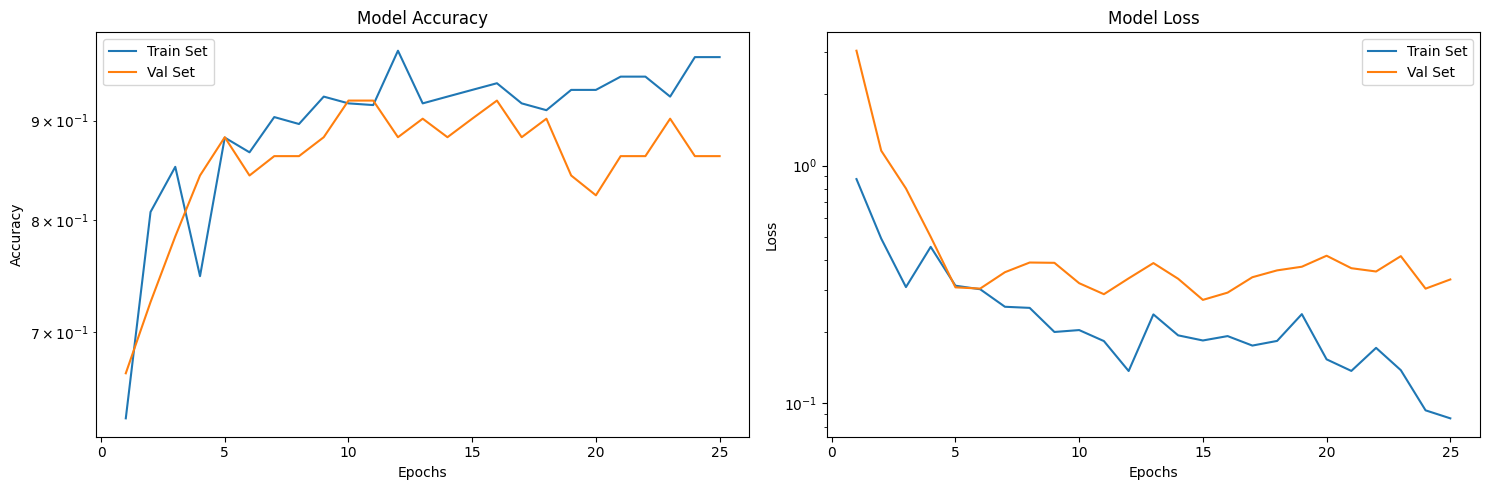

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(epochs_range, loss, label='Train Set', )
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test_norm)

2/2 [==============================] - 8s 3s/step


In [ ]:
y_pred = (y_pred_prob > 0.5).flatten()

In [ ]:
y_pred

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False])

In [ ]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

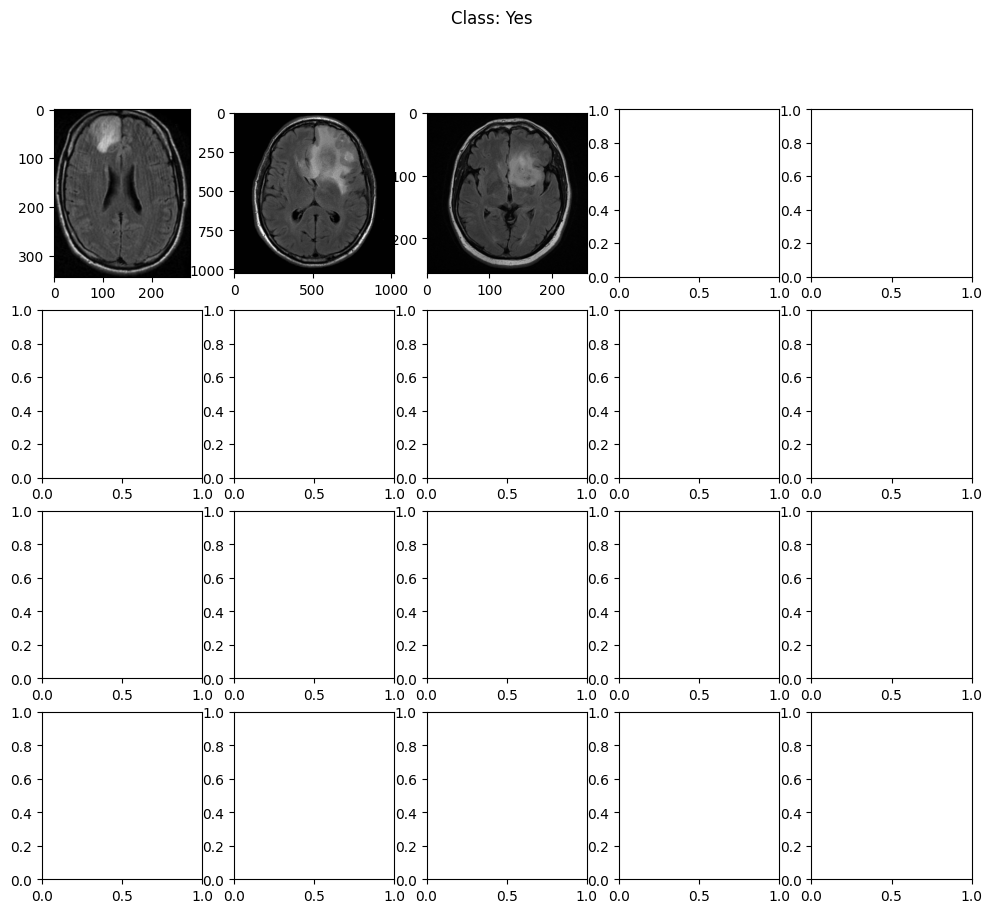

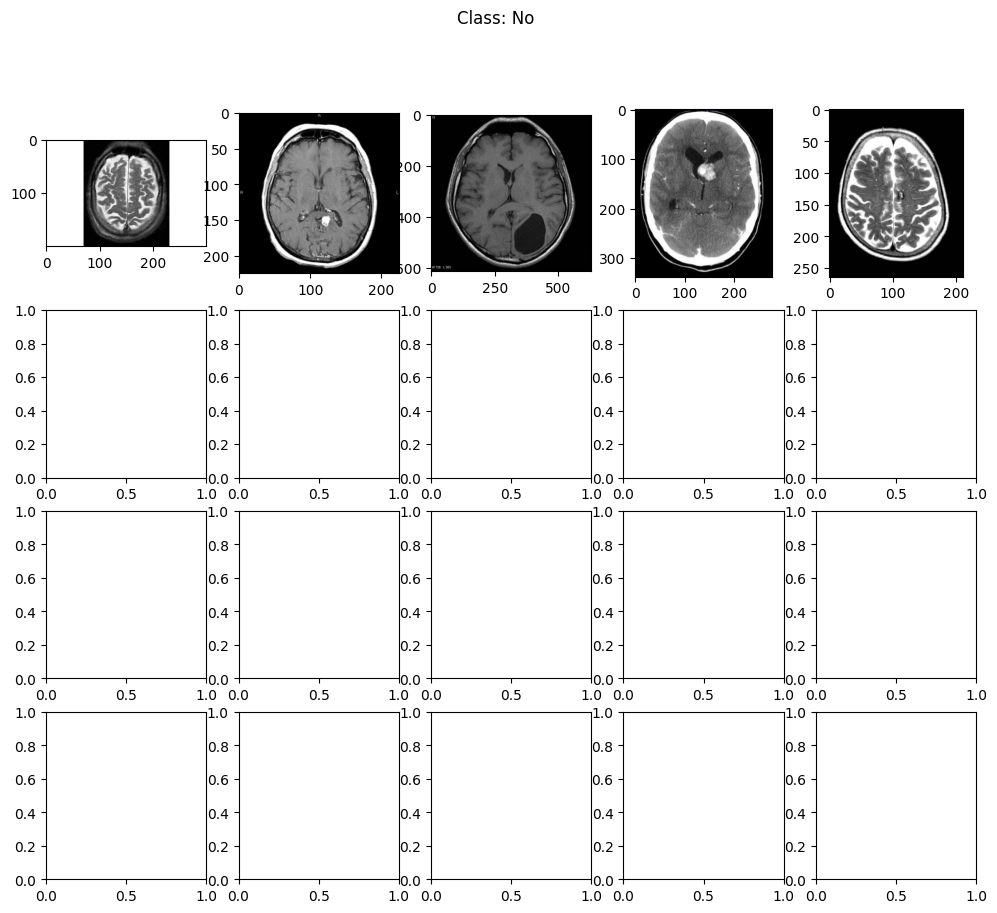

In [ ]:
not_ok_y_test = y_test[y_pred != y_test]
not_ok_X_test = X_test[y_pred != y_test]

display_images(not_ok_X_test, not_ok_y_test, 20)

recall =  0.9032258064516129
precision =  0.8484848484848485
f1 score =  0.875
rocauc =  0.8725806451612903


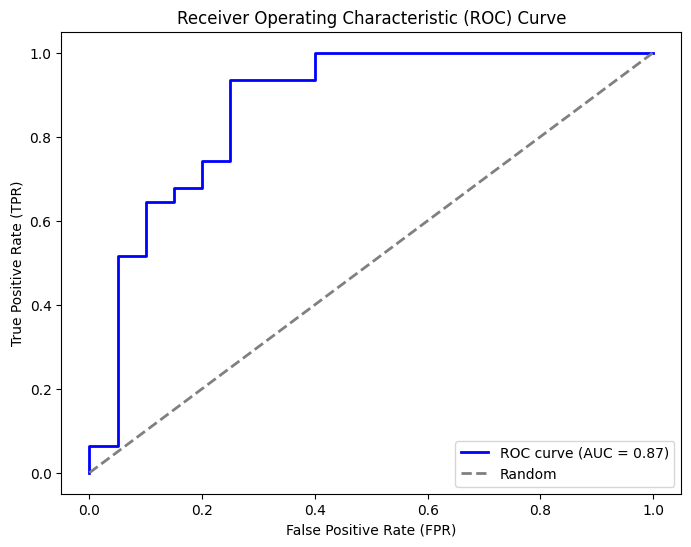

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve

print('recall = ', recall_score(y_test, y_pred))
print('precision = ', precision_score(y_test, y_pred))
print('f1 score = ', f1_score(y_test, y_pred))
print('rocauc = ', roc_auc_score(y_test, y_pred_prob))

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

(array([14.,  2.,  0.,  1.,  1.,  1.,  3.,  2.,  3., 24.]),
 array([6.79403747e-05, 9.98300686e-02, 1.99592188e-01, 2.99354315e-01,
        3.99116427e-01, 4.98878568e-01, 5.98640680e-01, 6.98402822e-01,
        7.98164964e-01, 8.97927046e-01, 9.97689188e-01]),
 <BarContainer object of 10 artists>)

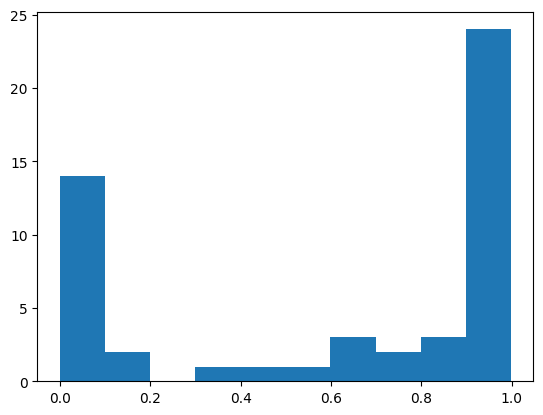

In [ ]:
plt.hist(y_pred_prob)

In [ ]:
model.save('my_model.h5')
# Code pour sauvegarder mon modele, on l'uttilise pour l'api 


c:\python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
